In [1]:
# Import necessary libraries for data manipulation and analysis
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load the engineered retail dataset from a CSV file into a pandas DataFrame
# Using sep=',' to explicitly specify the comma separator, although the file might have other formatting issues.
merged_df = pd.read_csv("../dataset/engineered_retail_dataset__for_ml.csv", sep=',')
# Display the first 5 rows of the DataFrame to get a preview of the data
merged_df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,Weekly_Sales_Lag2,Weekly_Sales_Lag3,Weekly_Sales_MA4,Weekly_Sales_STD4,Weekly_Sales_MA12,Weekly_Sales_STD12,IsHoliday_Lag1,IsHoliday_Lead1,Rolling_4,Rolling_12
0,1,1,2010-02-05,24924.50,False,42.31,2.572,0.0,0.0,0.0,...,0.00,0.00,0.00,0.000000,0.0,0.0,False,True,0.00,0.0
1,1,1,2010-02-12,46039.49,True,38.51,2.548,0.0,0.0,0.0,...,0.00,0.00,0.00,0.000000,0.0,0.0,False,False,0.00,0.0
2,1,1,2010-02-19,41595.55,False,39.93,2.514,0.0,0.0,0.0,...,24924.50,0.00,0.00,0.000000,0.0,0.0,True,False,0.00,0.0
3,1,1,2010-02-26,19403.54,False,46.63,2.561,0.0,0.0,0.0,...,46039.49,24924.50,0.00,0.000000,0.0,0.0,False,False,0.00,0.0
4,1,1,2010-03-05,21827.90,False,46.50,2.625,0.0,0.0,0.0,...,41595.55,46039.49,32990.77,12832.106391,0.0,0.0,False,False,32990.77,0.0


In [4]:
merged_df["Date"] = pd.to_datetime(merged_df["Date"])

In [5]:
# Define features (X) and target (y)
target = "Weekly_Sales"
features = [col for col in merged_df.columns if col not in ["Weekly_Sales", "Date"]]

X = merged_df[features]
y = merged_df[target]

In [6]:
# Aggregate at Store-Department level
seg_data = merged_df.groupby(['Store', 'Dept']).agg({
    'Weekly_Sales': 'mean',
    'IsHoliday': 'mean',
    'MarkDown1': 'mean',
    'MarkDown2': 'mean',
    'MarkDown3': 'mean',
    'MarkDown4': 'mean',
    'MarkDown5': 'mean'
}).reset_index()

# Fill NaNs if any
seg_data.fillna(0, inplace=True)

# Features for clustering
X = seg_data.drop(['Store','Dept'], axis=1)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

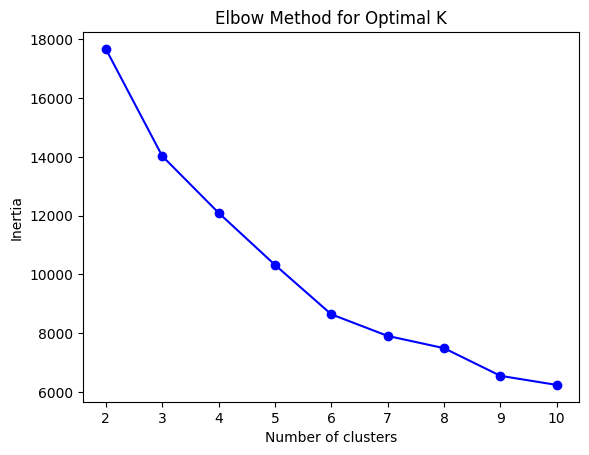

In [9]:
inertia = []
K = range(2, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()


C:\Users\uttam\anaconda3\envs\retail_ml\lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


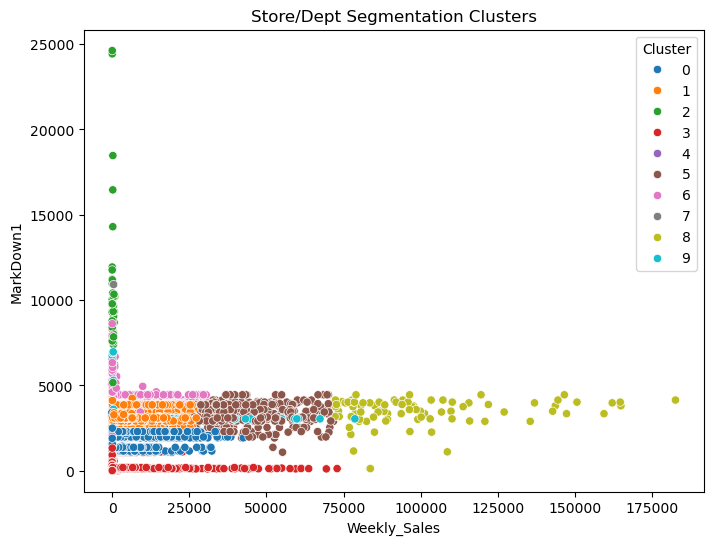

In [7]:
# Train final model with chosen K (say k=10)
kmeans = KMeans(n_clusters=10, random_state=42)
seg_data['Cluster'] = kmeans.fit_predict(X_scaled)

# Visualize clusters (using Store-Dept average sales)
plt.figure(figsize=(8,6))
sns.scatterplot(data=seg_data, x='Weekly_Sales', y='MarkDown1', hue='Cluster', palette='tab10')
plt.title("Store/Dept Segmentation Clusters")
plt.show()


### Insights:
- Data points are grouped into 10 distinct clusters, each representing a unique sales-markdown profile.
- Clusters help identify high-performing segments (e.g., high sales with high markdowns) versus low-engagement ones.
- Useful for targeted marketing, inventory planning, and personalized promotional strategies.
- This segmentation adds depth to the analysis by revealing behavioral patterns not visible in raw metrics.
